In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
from sf_lib.sf import get_running_vote_fraction

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_cols(df, cols):
    return df[cols].T.values

### Load dataframes:

In [3]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df = pd.read_json('df_stacked.json')

In [4]:
workflows = df['workflow_name'].unique().tolist()
print(workflows)

['Classify! Hardcore edition', 'Classify!', 'Classify on the go!']


### Extract classifications per workflow:

In [5]:
hc = df.query('workflow_name == @workflows[0]')
classify = df.query('workflow_name == @workflows[1]')
onthego = df.query('workflow_name == @workflows[2]')

#### Extract normalized `T0` value counts:

In [6]:
t0_clas, t0_hc, t0_onthego = [df.groupby('Filename')['T0'].value_counts(normalize=True) for df in [classify, hc, onthego]]

#### Create hashtable of object names and normalized counts per answer type:

In [7]:
def make_t0_hashtable(df):
    table = {}
    for k, v in list(df.items()):
        name, ans = k

        if not table.get(name):
            table[name] = {}

        table[name][ans] = v
    
    return table

In [8]:
hashes = hash_clas, hash_hc, hash_onthego = [make_t0_hashtable(df.to_dict()) for df in [t0_clas, t0_hc, t0_onthego]]

In [9]:
hash_titles = ['Classify', 'Hardcore', 'On-the-Go']

### Create points to plot 
Points are like (x, y) with the x-value being the percentage in one workflow, adn the y-value being the percentage in the other workflow, for the given answer type.

In [10]:
def make_T0_comparison_points(ans, df1, df2):
    names = set(df1.keys()) & set(df2.keys())
    points = []
    for name in names:
        x = df1.get(name).get(ans, 0)
        y = df2.get(name).get(ans, 0)
        points.append((x, y))
    return np.array(points).T

In [11]:
np.array(np.array([1,2,3]))

array([1, 2, 3])

In [12]:
def pfit(xs, ys, deg):
    xs = np.array(xs)
    ys = np.array(ys)
    p = np.polyfit(xs, ys, deg)[::-1]
    
    xs = np.linspace(xs.min(), xs.max(), int(1e4))
    return xs, sum([p[i]*xs**i for i in range(len(p))])

### Create function to plot the fraction of answers for each T0 answer, between two workflows:

In [13]:
def plot_t0_correlation(i, j, savepath=None):
    fig, fr = plt.subplots(1,3, figsize=(12,4))

    t0_answers = classify['T0'].value_counts().keys().tolist()
    for index, ans in enumerate(t0_answers):
        xs, ys = make_T0_comparison_points(ans, hashes[i], hashes[j])

        kw = { "s": 5, "alpha": 0.8, "c": np.abs(ys-xs), 'cmap': 'plasma_r' }

        sc = fr[index].scatter(xs, ys, **kw)
        fig.colorbar(sc, ax=fr[index])

        fr[index].plot(*pfit(xs, ys, 1), lw=1.5, ls='--', c='#222')

        dx = 0.01
        fr[index].update({
            "xlim": [-dx,1+dx],
            "ylim": [-dx, 1+dx],
            "title": '{}'.format(ans.capitalize()),
            "xlabel": hash_titles[i],
            "ylabel": hash_titles[j]
        })
        fr[index].text(0.75,-0.18, 'corr: {}'.format(round(np.corrcoef(xs, ys)[0,1], 2)), bbox=dict(edgecolor='black', facecolor='white', alpha=0.5))
        fr[index].grid(alpha=0.3)

    fig.suptitle('Fraction T0 votes per object per answer type, {} vs. {}'.format(hash_titles[i], hash_titles[j]))
    fig.tight_layout()
    
    if savepath:
        plt.savefig(savepath, dpi=450)
    plt.show()

### Plot correlations between T0 answers for every combination of workflows:

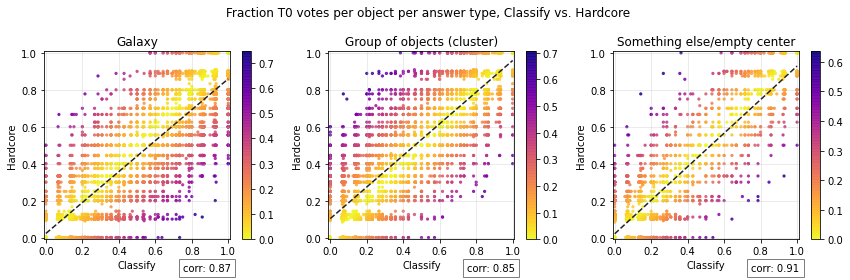

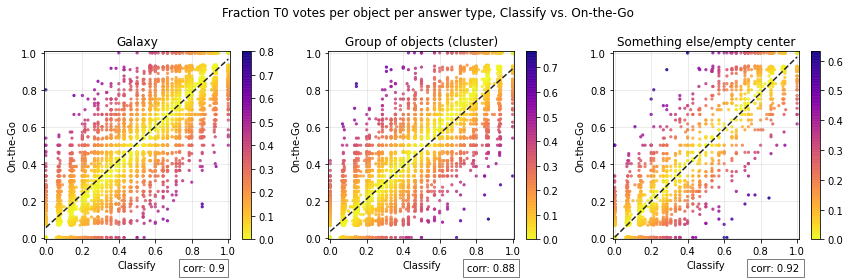

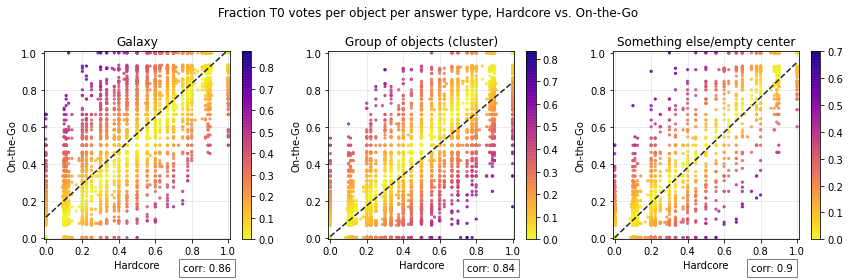

In [14]:
from itertools import combinations
tuples = list(combinations(list(range(3)), 2))

for tup in tuples:
    i, j = tup
    plot_t0_correlation(i, j, savepath="correlate workflows {} {}.png".format(i, j))

### Plot votes per object for individual workflows, and then for the stacked dataframe

In [15]:
dfs = [classify, hc, onthego, df]
labels = ['Classify', 'Hardcore', 'On-the-Go', 'Combined']
vote_counts = []
for i, frame in enumerate(dfs):
    groupby_name = frame[['Filename', 'T0']].groupby('Filename')
    counts = groupby_name.agg('count')['T0'].tolist()
    vote_counts.append(counts)

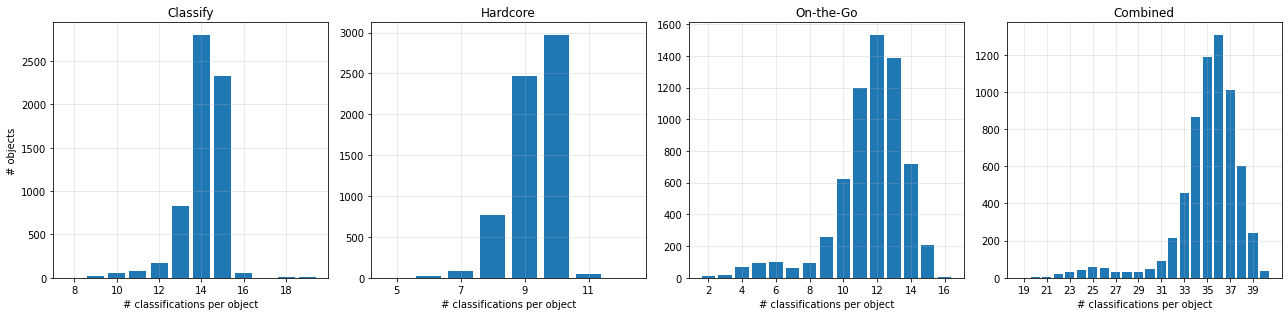

In [16]:
fig, fr = plt.subplots(1,4, figsize=(18,4.5))
for i, entry in enumerate(vote_counts):
    fr[i].bar(*np.unique(vote_counts[i], return_counts=True))
    fr[i].update(dict(
        xticks=np.arange(min(vote_counts[i]), max(vote_counts[i])+1, 2),
        xlabel='# classifications per object',
        title=labels[i]
    ))
    fr[i].grid(alpha=0.3)
    
fr[0].update(dict(ylabel='# objects'))

fig.tight_layout()
plt.savefig('classification count per object per workflow.png', dpi=400)
plt.show()

### Number of classifications per user across workflows:

workflow   mean  median stdev       
Classify   50.36  14.00 162.68
Hardcore   40.32   9.00 121.89
On-the-Go  87.48  12.00 345.77
Combined   60.29  11.00 239.06


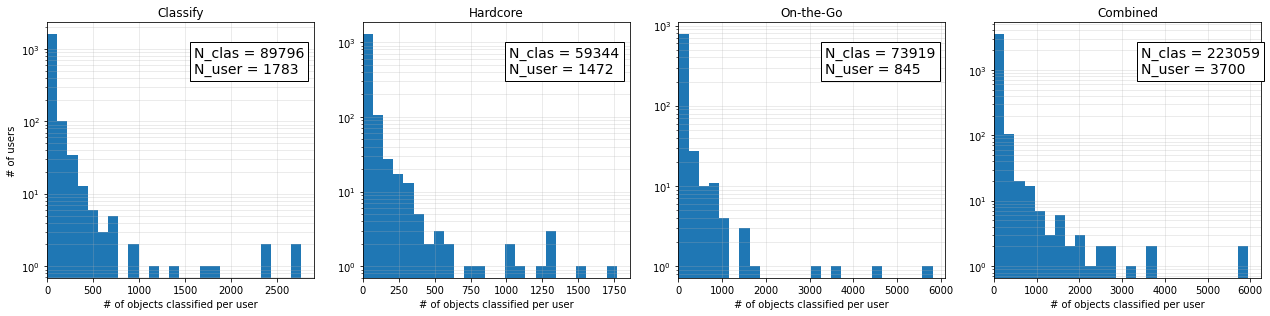

In [28]:
from scipy.stats import describe

fig, fr = plt.subplots(1, 4, figsize=(18, 4.5))

print('{:10s} {:5s} {:6s} {:12s}'.format('workflow', 'mean', 'median', 'stdev'))
for i, frame in enumerate(dfs):
    t0count = frame.groupby('user_name').agg('count')['T0'].tolist()
    mean = np.mean(t0count)
    std = np.std(t0count)
    median = np.median(t0count)
    
    fr[i].hist(t0count, bins=25)
    fr[i].update(dict(
        yscale="log",
        xlabel="# of objects classified per user",
        xlim=(0),
        title=labels[i]
    ))
    bbox=dict(facecolor='white', edgecolor='black')
    fr[i].grid(alpha=0.3, which='both')
    fr[i].text(0.55, 0.8, "N_clas = {}\nN_user = {}".format(sum(t0count), len(t0count)), transform=fr[i].transAxes, bbox=bbox, fontsize=14)
    print('{:10s} {:3.2f} {:6.2f} {:3.2f}'.format(labels[i], round(mean, 2), round(median, 2), round(std, 2)))
    
fr[0].update(dict(ylabel="# of users"))
fig.tight_layout()
plt.savefig('votes per user.png', dpi=450)
plt.show()

## Running vote fraction

In [35]:
fraction_classify = get_running_vote_fraction(classify)
fraction_onthego = get_running_vote_fraction(onthego)
fraction_hc = get_running_vote_fraction(hc)
fraction_stacked = get_running_vote_fraction(df)

In [50]:
def plot_running_vote_fraction(data):
    fig, fr = plt.subplots(1,2, figsize=(10,5))

    scales = ['linear', 'log']

    for index, _ in enumerate(data):
        counts, running_fraction, label, ls = data[index].values()
        for i in range(len(fr)):
            fr[i].plot(counts, running_fraction, label=label, ls=ls)

    for i in range(len(fr)):
        fr[i].update({
            'xlabel': r'$n$',
            'xscale': scales[i],
            'xlim': (0),
            'ylim': (0,1)
        })

        fr[i].grid(which='both', alpha=0.3)
        fr[i].legend()
    
    fr[0].update(dict(ylabel="Cumulative vote fraction"))
    fig.suptitle("Fraction of votes cast by all users that made at least $n$ classifications")
    
    fig.tight_layout()
    plt.savefig('running vote fraction.png', dpi=350)
    plt.show()

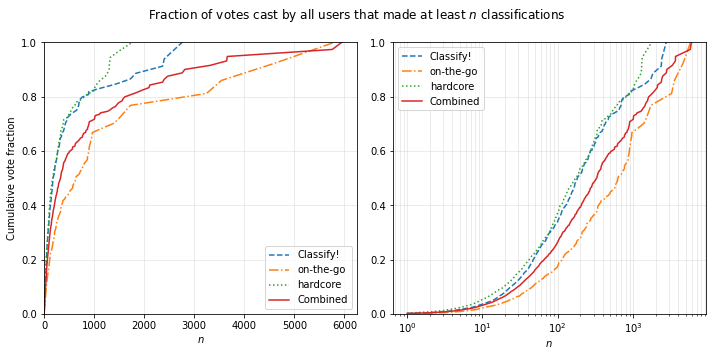

In [51]:
plot_running_vote_fraction([
    {
        'counts': fraction_classify[2],
        'running_fraction': fraction_classify[3],
        'label': 'Classify!',
        'ls': '--'
    },
    {
        'counts': fraction_onthego[2],
        'running_fraction': fraction_onthego[3],
        'label': 'on-the-go',
        'ls': '-.'
    },
    {
        'counts': fraction_hc[2],
        'running_fraction': fraction_hc[3],
        'label': 'hardcore',
        'ls': ':'
    },
    dict(
        count=fraction_stacked[2],
        running_fraction=fraction_stacked[3],
        label="Combined",
        ls='-'
    )  
])